
# TIG Level-1: Single-Asset Temporal Arbitrage


This notebook is a complete, **solver-facing** reference for **Level 1** of the TIG challenge (single battery, temporal arbitrage).
It is **self-contained** (no internet, no external solvers) and includes:

1. **Problem recap** and modeling assumptions  
2. **Instance generation** (stochastic RT price scenarios + battery params)  
3. **Environment simulator** (physics + frictions + accounting)  
4. **Metrics & verification** (profit, CVaR, std, cycles; hard constraint checks)  
5. **Visualization** helpers (prices, actions, SOC, profit decomposition)  
6. **Baseline policy**: simple **Greedy Threshold** rule  
7. **Improved policy**: **Rolling-Horizon DP (MPC)** over expected/robust prices  
8. **Evaluation** across many hidden-like scenarios  
9. **(Optional) Policy Table export** compatible with an Option-A submission



## 1. Problem Recap (Level-1)

### Level-1 Variables (Single-Asset Temporal Arbitrage)

| Variable (Symbol) | Domain / Units | Meaning |
|---|---|---|
| **Time & Scenarios** |||
| $T$ | finite set of time indices (e.g., $\{0,\dots,23\}$) | Horizon (number of decision steps). |
| $t$ | integer index $t\in T$ | A specific time step. |
| $\Delta t$ | $\mathbb{R}_{>0}$ (hours) | Duration of each step (usually 1 h). |
| $\Omega$ | finite set | Real-time price scenarios used for training/eval. |
| $\omega$ | integer index $\omega\in\Omega$ | A specific scenario. |
| **Prices & Frictions** |||
| $\pi_{t,\omega}$ | $\mathbb{R}_{\ge 0}$ $[\$/\text{MWh}]$ | Real-time price at time $t$ under scenario $\omega$. |
| $\pi^{DA}_t$ | $\mathbb{R}_{\ge 0}$ $[\$/\text{MWh}]$ | Day-Ahead reference price (deterministic curve). |
| $\text{tc}$ | $[0,1)$ | Transaction cost (fraction) applied symmetrically to buys/sells. |
| $\text{deg}$ | $\mathbb{R}_{\ge 0}$ $[\$/\text{MWh}]$ | Degradation cost per discharged MWh. |
| **Battery State & Controls** |||
| $\text{SOC}_t$ | $\mathbb{R}$ $[\text{MWh}]$ | State of charge at end of time $t$. |
| $p^c_{t,\omega}$ | $\mathbb{R}_{\ge 0}$ $[\text{MW}]$ | Charging power at $t$ in scenario $\omega$. |
| $p^d_{t,\omega}$ | $\mathbb{R}_{\ge 0}$ $[\text{MW}]$ | Discharging power at $t$ in scenario $\omega$. |
| $u^c_t$ | $\{0,1\}$ | Charging mode ON/OFF at $t$. |
| $u^d_t$ | $\{0,1\}$ | Discharging mode ON/OFF at $t$. |
| **Battery Limits & Efficiencies** |||
| $\text{SOC}_{\min}$ | $\mathbb{R}$ $[\text{MWh}]$ | Minimum allowable SOC. |
| $\text{SOC}_{\max}$ | $\mathbb{R}$ $[\text{MWh}]$ | Maximum SOC (= capacity). |
| $P^{c}_{\max}$ | $\mathbb{R}_{>0}$ $[\text{MW}]$ | Max charge power. |
| $P^{d}_{\max}$ | $\mathbb{R}_{>0}$ $[\text{MW}]$ | Max discharge power. |
| $\eta_c$ | $(0,1]$ | Charging efficiency. |
| $\eta_d$ | $(0,1]$ | Discharging efficiency. |
| **SOC Dynamics & Objective** |||
| — | — | $\text{SOC}_t=\text{SOC}_{t-1}+(\eta_c p^c_{t,\omega}-p^d_{t,\omega}/\eta_d)\,\Delta t$ |
| — | — | Profit per step $=\big[(1-\text{tc})\pi_{t,\omega}p^d_{t,\omega}-(1+\text{tc})\pi_{t,\omega}p^c_{t,\omega}-\text{deg}\,p^d_{t,\omega}\big]\Delta t$ |

> **Mutual exclusivity:** enforce $u^c_t+u^d_t\le 1$ and couple power limits: $0\le p^c_{t,\omega}\le u^c_t P^{c}_{\max}$, $0\le p^d_{t,\omega}\le u^d_t P^{d}_{\max}$.

---

We control **one battery** over a finite horizon $t = 0,\dots,T-1$ with step $\Delta t$.  
At each step choose charge $p^c_t \ge 0$ or discharge $p^d_t \ge 0$ (not both), bounded by power limits.
The **State of Charge (SOC)** (MWh) evolves as
\begin{aligned}
SOC_t = SOC_{t-1} + \big(\eta_c\,p^c_t - \frac{p^d_t}{\eta_d}\big)\,\Delta t,
\qquad SOC_{\min} \le SOC_t \le SOC_{\max}.
\end{aligned}
Per-period profit (before $\Delta t$) is:
\begin{aligned}
(1-\text{tc}) \cdot \pi_t \cdot p^d_t \;-\; (1+\text{tc}) \cdot \pi_t \cdot p^c_t \;-\; \text{deg} \cdot p^d_t,
\end{aligned}
where $\pi_t$ is the **real-time** price, `tc` is a transaction-cost rate, and `deg` is a degradation $/MWh on discharge.


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, linewidth=120)
pd.set_option("display.width", 160)


## 2. Instance Generation

The instance generator creates **self-contained problem data** for the single-battery temporal arbitrage task:

- A **Day-Ahead (DA) baseline curve** $\pi^{DA}_t$ (deterministic, length $T$).
- A **matrix of Real-Time (RT) price scenarios** $\pi_{t,\omega}$ with shape $(T, N)$ to *train/evaluate* policies.
- A **BatterySpec** with all physical limits and efficiencies.
- **Frictions** (transaction fee, degradation cost).

This lets solvers develop/benchmark algorithms **without** needing external data sources.

### Inputs (function parameters)

- `T: int = 24`  
  Horizon length (number of steps). If you change `T`, the DA curve is smoothly **interpolated** to match that length.

- `volatility: float = 0.2`  
  Standard deviation of **multiplicative Gaussian noise** applied to the DA curve to produce RT scenarios. Formally, for each $t$:
  \begin{align}
  \pi_{t,\omega} \;=\; \max\{0,\ \pi^{DA}_t \cdot (1 + \varepsilon_{t,\omega})\},
  \quad \varepsilon_{t,\omega}\sim\mathcal{N}(0,\ \text{volatility})
  \end{align}
  (Clamping with $\max\{0,\cdot\}$ prevents negative prices; you can remove this if you wish to allow negative RT prices.)

- `tail_risk_factor: float = 0.05`  
  Probability that an **extreme spike** occurs in a random late-day hour for a given scenario. When triggered, one hour $h$ (drawn from a late range, e.g., $[0.6T, 0.85T]$) gets multiplied by a spike factor $s \in [2,5]$. This injects **rare but large** price shocks that stress test arbitrage strategies.

- `seed: int = 42`  
  Random seed for reproducibility and fair comparisson (controls Gaussian noise, spike timing, and magnitude).

> In the notebook, we default to **$N=200$** scenarios. You can adjust this inside the function if you want more/less training variety.

### Day-Ahead (DA) curve

We start from a stylized 24-point DA price shape:
\begin{align}
[30, 28, 25, 26, 35, 50, 65, 70, 68, 60, 55, 53, 50, 52, 58, 68, 80, 90, 75, 60, 50, 40, 35, 32]
\end{align}
If `T≠24`, we linearly **interpolate** to length `T`. The DA curve serves as:
- A **reference** (some policies compare RT vs DA at the same hour).
- The **mean** around which RT scenarios fluctuate.

### Real-Time (RT) scenario generation

For each scenario $\omega=1,\dots,N$:

1) **Gaussian multiplicative noise** per hour:  
   $\pi_{t,\omega}=\pi^{DA}_t(1+\varepsilon_{t,\omega})$ with $\varepsilon\sim\mathcal{N}(0,\text{volatility})$.

2) **Tail spike** (with probability `tail_risk_factor`):  
   Choose a random hour $h$ toward the late part of the day; multiply $\pi_{h,\omega}$ by a factor $s \in [2,5]$. This emulates e.g. surprise shortfalls near peak demand.

3) **Clamp to non-negative**:  
   $\pi_{t,\omega}\leftarrow\max(0,\pi_{t,\omega})$.

The result is a **T×N** matrix `rt_prices`, where each column is one scenario path.

> **Why multiplicative noise?** Prices are positive and relative variability scales with the price level; this is a simple, realistic caricature. You can swap to additive noise if you prefer.



In [ ]:
# === CONFIG (GP-focused) ===
from dataclasses import dataclass

@dataclass
class Cfg:
    T: int = 24
    dt_h: float = 1.0
    mean_price: float = 50.0

    # GP kernel params (periodic + SE)
    gp_sigma_p: float = 12.0
    gp_ell_p: float = 0.7
    gp_sigma_se: float = 6.0
    gp_ell_se: float = 6.0
    gp_sigma_n: float = 1.0
    gp_period_hours: int = 24

    # RT noise/tails (unchanged behavior; use your existing RT code)
    sigma_pi: float = 0.25
    tail_prob: float = 0.03


In [ ]:
# === GP DAY-AHEAD GENERATOR ===
import numpy as np

def _periodic_kernel(t, t2, sigma_p, ell_p, P):
    tau = np.abs(t[:, None] - t2[None, :])
    return (sigma_p**2) * np.exp(-2.0 * np.sin(np.pi * tau / P)**2 / (ell_p**2))

def _se_kernel(t, t2, sigma_se, ell_se):
    tau2 = (t[:, None] - t2[None, :])**2
    return (sigma_se**2) * np.exp(-tau2 / (2.0 * ell_se**2))

def day_ahead_gp(cfg: Cfg, rng: np.random.Generator) -> np.ndarray:
    T = cfg.T
    t = np.arange(T, dtype=float)
    K = (
        _periodic_kernel(t, t, cfg.gp_sigma_p, cfg.gp_ell_p, cfg.gp_period_hours) +
        _se_kernel(t, t, cfg.gp_sigma_se, cfg.gp_ell_se) +
        (cfg.gp_sigma_n**2) * np.eye(T)
    )
    L = np.linalg.cholesky(K + 1e-8 * np.eye(T))  # jitter for stability
    z = rng.standard_normal(T)
    sample = L @ z + cfg.mean_price
    return np.clip(sample, 0.0, None)


In [ ]:
from dataclasses import dataclass

@dataclass
class BatterySpec:
    capacity_mwh: float
    power_mw: float
    efficiency_c: float
    efficiency_d: float
    soc_initial_mwh: float
    soc_min_mwh: float
    soc_max_mwh: float

@dataclass
class Frictions:
    transaction_cost_pct: float = 0.0
    degradation_cost_per_mwh: float = 0.0

def generate_level1_instance(
    T: int = 24,
    volatility: float = 0.2,
    tail_risk_factor: float = 0.05,
    seed: int = 42
):

    # inside your Environment.__init__
    cfg=Cfg
    rng = np.random.default_rng(seed)
    base_da = day_ahead_gp(cfg,rng)  # <— use GP day-ahead

    #base_da = np.array([30, 28, 25, 26, 35, 50, 65, 70, 68, 60, 55, 53, 50, 52, 58, 68, 80, 90, 75, 60, 50, 40, 35, 32], dtype=float)
    if len(base_da) != T:
        base_da = np.interp(np.linspace(0, len(base_da)-1, T), np.arange(len(base_da)), base_da)

    N = 200
    scenarios = []
    for _ in range(N):
        noise = rng.normal(0.0, volatility, T)
        scen = base_da * (1.0 + noise)
        if rng.uniform() < tail_risk_factor:
            h = rng.integers(low=int(0.6*T), high=int(0.85*T))
            scen[h] *= (2.0 + rng.uniform(0.0, 3.0))
        scenarios.append(np.maximum(0.0, scen))
    rt_prices = np.stack(scenarios, axis=1)

    batt = BatterySpec(
        capacity_mwh = 100.0,
        power_mw     = 25.0,
        efficiency_c = 0.95,
        efficiency_d = 0.95,
        soc_initial_mwh = 50.0,
        soc_min_mwh     = 0.0,
        soc_max_mwh     = 100.0
    )
    fric = Frictions(transaction_cost_pct=0.01, degradation_cost_per_mwh=0.5)
    return base_da, rt_prices, batt, fric

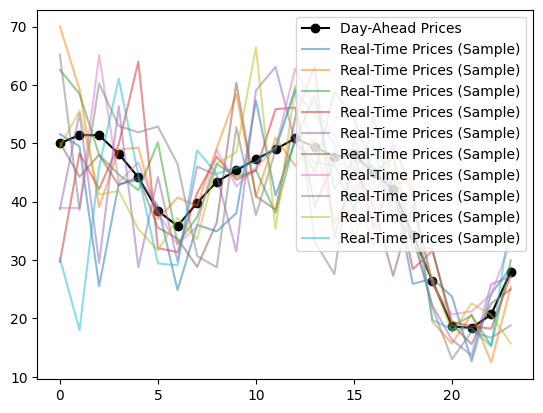

In [ ]:
base_da, rt_prices, batt, fric = generate_level1_instance(
    T=24, volatility=0.2, tail_risk_factor=0.05, seed=7
)

import matplotlib.pyplot as plt

plt.plot(base_da, label='Day-Ahead Prices', marker='o', color='black')
plt.plot(rt_prices[:, :10], label='Real-Time Prices (Sample)', alpha=0.5)
plt.legend()

Let's now test the GP with a different seed

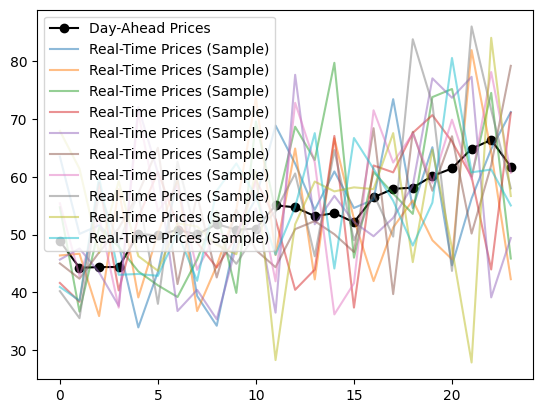

In [ ]:
base_da, rt_prices, batt, fric = generate_level1_instance(
    T=24, volatility=0.2, tail_risk_factor=0.05, seed=70
)

import matplotlib.pyplot as plt

plt.plot(base_da, label='Day-Ahead Prices', marker='o', color='black')
plt.plot(rt_prices[:, :10], label='Real-Time Prices (Sample)', alpha=0.5)
plt.legend()


## 3. Environment Simulator (Physics + Profit)


### Environment Simulation (Level-1, Single-Asset)

This describes exactly how the **simulator** steps the battery through time given your policy’s actions and the realized price path. It matches the notebook’s `step_env(...)` function.



####  What the simulator is

A **deterministic, single-step transition** function that evolves the environment from state `s_t` to `s_{t+1}` given:
- your chosen **action** (charge/discharge power),
- the **realized real-time price** at time `t`,
- the **battery physics** and **frictions**,
- and the **time step** `Δt`.

It is intentionally small and transparent so any algorithm can plug in.



### State, Action, Observation

#### State (tracked internally)
- `t ∈ {0,…,T}`: current time index (after the step it becomes `t+1`)
- `SOC` (MWh): state of charge at the *end* of the last step
- `profit` ($): cumulative profit up to and including the last step
- `feasible ∈ {True, False}`: whether any constraint has been violated so far

### Action
- `a_t` (MW): a **single scalar power set-point**
  - `a_t > 0` ⇒ **charge** with `p^c_t = a_t`, `p^d_t = 0`
  - `a_t < 0` ⇒ **discharge** with `p^d_t = -a_t`, `p^c_t = 0`
  - `a_t = 0` ⇒ **hold**
- The simulator **clips** to power limits: `|a_t| ≤ P_max`.

> This design **enforces mutual exclusivity** (no simultaneous charge & discharge) by construction.

#### Observation (inputs you may use to decide)
At time `t` your agent/policy can be given:
- current **RT price** `π_t`,
- optional **DA price** `π^DA_t` (if the instance allows),
- **current SOC**, **time t**, and any other **allowed** present-time signals.

No future info is exposed.



#### Physics & Accounting

Given state `(t, SOC, profit, feasible)`, action `a_t`, and price `π_t`:

1) **Clip to power limits**  
   `a_t ← clip(a_t, −P_max, +P_max)`

2) **Mode split (exclusivity)**  
   `p^c_t = max(0, a_t)`, `p^d_t = max(0, −a_t)`

3) **SOC dynamics**  
   `SOC_{t+1} = SOC_t + (η_c * p^c_t − p^d_t / η_d) * Δt`

4) **Bounds check**  
   `feasible_{t+1} = [ SOC_min ≤ SOC_{t+1} ≤ SOC_max ]`  
   - If **violated**, the simulator marks the episode infeasible and applies a large **penalty** to the objective for this step (e.g., `−1e6`).  
   - (Alternative designs are possible—e.g., hard-clipping SOC instead of penalizing—but the notebook uses **penalty for violation** to keep incentives clean.)

5) **Profit for the step** (with frictions)
   - Transaction cost (fraction) on **both** buying and selling: `tc`
   - Degradation cost per discharged MWh: `deg`  
   `Δprofit_t = [ (1−tc) * π_t * p^d_t  −  (1+tc) * π_t * p^c_t  −  deg * p^d_t ] * Δt`  
   - If the step is infeasible, we **replace** this with the penalty.

6) **Accumulate & advance**  
   `profit_{t+1} = profit_t + Δprofit_t`, and `t ← t+1`



###  Episode Loop

For a realized price path `(π_0,…,π_{T-1})`:

1. Initialize `t=0`, `SOC=SOC_0`, `profit=0`, `feasible=True`.
2. For `t = 0,…,T−1`:
   - Provide the **current observation** to your policy.
   - Get action `a_t`.
   - Apply the **step** rules above to produce the next state.
3. Return cumulative **profit**, **feasible** flag, and traces (SOC, actions, charge/discharge series).



In [ ]:
from dataclasses import dataclass

@dataclass
class EnvState:
    t: int
    soc: float
    profit: float
    feasible: bool

def step_env(
    state: EnvState,
    action_power_mw: float,  # + = charge, - = discharge
    price: float,
    batt: BatterySpec,
    fric: Frictions,
    delta_t: float = 1.0
) -> EnvState:
    if not state.feasible:
        return state

    P = batt.power_mw
    a = float(np.clip(action_power_mw, -P, P))

    p_c = max(0.0, a)
    p_d = max(0.0, -a)

    soc_next = state.soc + (batt.efficiency_c * p_c - (p_d / batt.efficiency_d)) * delta_t

    feasible = (batt.soc_min_mwh - 1e-9) <= soc_next <= (batt.soc_max_mwh + 1e-9)

    tc = fric.transaction_cost_pct
    deg = fric.degradation_cost_per_mwh
    step_profit = ((1 - tc) * price * p_d - (1 + tc) * price * p_c - deg * p_d) * delta_t

    return EnvState(
        t = state.t + 1,
        soc = soc_next,
        profit = state.profit + (step_profit if feasible else -1e6),
        feasible = feasible
    )


## 4. Metrics & Visualization Helpers


In [ ]:
def eval_metrics(profits):
    profits = np.asarray(profits, dtype=float)
    mean = float(np.mean(profits))
    std = float(np.std(profits, ddof=1)) if len(profits) > 1 else 0.0
    alpha = 0.05
    k = max(1, int(math.ceil(alpha * len(profits))))
    worst = np.partition(profits, k-1)[:k]
    cvar5 = float(np.mean(worst))
    return {"expected_profit": mean, "cvar_5": cvar5, "std": std}

def cycles_from_trace(discharge_MW, delta_t, capacity_mwh):
    discharged_mwh = float(np.sum(np.maximum(0.0, discharge_MW)) * delta_t)
    return discharged_mwh / capacity_mwh if capacity_mwh > 0 else 0.0

def plot_prices_with_action(prices, actions, title="Prices & Action"):
    T = len(prices)
    plt.figure(figsize=(10,4))
    plt.plot(range(T), prices, label="RT price")
    plt.step(range(T), actions, where='post', label="action P (MW)")
    plt.title(title); plt.xlabel("t"); plt.ylabel("price / power"); plt.legend(); plt.show()

def plot_soc(soc, title="State of Charge"):
    T = len(soc)
    plt.figure(figsize=(10,3.6))
    plt.step(range(T), soc, where='post')
    plt.title(title); plt.xlabel("t"); plt.ylabel("SOC (MWh)"); plt.show()

def plot_profit_bars(charge_MW, discharge_MW, price, fric, delta_t=1.0, title="Profit components"):
    P_sell = (1 - fric.transaction_cost_pct) * price * discharge_MW * delta_t
    C_buy  = (1 + fric.transaction_cost_pct) * price * charge_MW * delta_t
    C_deg  = fric.degradation_cost_per_mwh * discharge_MW * delta_t
    net    = P_sell - C_buy - C_deg
    plt.figure(figsize=(10,4))
    plt.plot(P_sell, label="Sell revenue")
    plt.plot(-C_buy, label="Buy cost (neg)")
    plt.plot(-C_deg, label="Degradation (neg)")
    plt.plot(net, label="Net per period")
    plt.title(title); plt.xlabel("t"); plt.ylabel("value per step"); plt.legend(); plt.show()


## 5. Baseline Policy — Greedy Threshold

## Greedy Threshold (myopic but fast)
Think of the battery like a water tank and the price as today’s gas price on a roadside sign.

- **Rule of thumb:**  
  If the current real-time (RT) price is **cheap** compared to a simple reference (e.g., the Day-Ahead price at the same hour), **fill the tank** (charge).  
  If RT is **expensive** vs. that reference, **empty the tank** (discharge).  
  Otherwise, **do nothing**.

- **Buffers** keep you from slamming into empty/full (SOC min/max).

- **Why it works:** it captures obvious “buy-low / sell-high **right now**” opportunities.

- **Why it can fail:** it has **no sense of tomorrow**. If a spike is likely in a few hours, greedy might waste headroom by charging too little (or too late), or over-cycle when spreads are mediocre.



### Parameters (class `GreedyParams`)
- `buy_threshold` (default `0.95`): if `RT < buy_threshold * DA` ⇒ **charge**.
- `sell_threshold` (default `1.05`): if `RT > sell_threshold * DA` ⇒ **discharge**.
- `soc_buffer_low`, `soc_buffer_high` (fractions of capacity): reserves to avoid hitting SOC min/max.

> You can change DA for any admissible present-time reference (e.g., a moving average of past RT). What matters is **non-anticipativity**.

### Decision Rule (per step `t`)
Given:
- current `rt_price = π_t`, reference `da_price = π^DA_t`,
- current `SOC_t`, limits `[SOC_min, SOC_max]`,
- symmetric power limit `P_max`,

1. Compute buffered SOC window:
   - `lo = SOC_min + soc_buffer_low * capacity`
   - `hi = SOC_max - soc_buffer_high * capacity`
2. If `SOC_t < hi` **and** `π_t < buy_threshold * π^DA_t` ⇒ `action = +P_max` (charge)  
3. Else if `SOC_t > lo` **and** `π_t > sell_threshold * π^DA_t` ⇒ `action = −P_max` (discharge)  
4. Else ⇒ `action = 0` (hold)

The environment converts the signed `action` into `(p^c_t, p^d_t)` with **exclusive** modes and updates SOC and profit.

### Pseudocode
```text
if SOC < hi and RT < buy_threshold * DA:
    a = +P_max
elif SOC > lo and RT > sell_threshold * DA:
    a = -P_max
else:
    a = 0
```


In [ ]:
from dataclasses import dataclass

@dataclass
class GreedyParams:
    buy_threshold: float = 0.95
    sell_threshold: float = 1.05
    soc_buffer_low: float = 0.02
    soc_buffer_high: float = 0.02

def greedy_action(rt_price, da_price, state: EnvState, batt: BatterySpec, gp: GreedyParams):
    P = batt.power_mw
    lo = batt.soc_min_mwh + gp.soc_buffer_low * batt.capacity_mwh
    hi = batt.soc_max_mwh - gp.soc_buffer_high * batt.capacity_mwh

    a = 0.0
    if state.soc < hi and rt_price < gp.buy_threshold * da_price:
        a = +P
    elif state.soc > lo and rt_price > gp.sell_threshold * da_price:
        a = -P
    return a

def simulate_policy(prices, da_prices, batt, fric, policy_fn, policy_params, delta_t=1.0):
    T = len(prices)
    state = EnvState(t=0, soc=batt.soc_initial_mwh, profit=0.0, feasible=True)
    actions = np.zeros(T); socs = np.zeros(T)
    charge = np.zeros(T); discharge = np.zeros(T)

    for t in range(T):
        a = policy_fn(prices[t], da_prices[t], state, batt, policy_params)
        next_state = step_env(state, a, prices[t], batt, fric, delta_t=delta_t)
        actions[t] = a; socs[t] = next_state.soc
        charge[t] = max(0.0, a); discharge[t] = max(0.0, -a)
        state = next_state

    return {"actions": actions, "soc": socs, "profit": state.profit, "feasible": state.feasible,
            "charge_MW": charge, "discharge_MW": discharge}


## 6. Improved Policy — Rolling-Horizon DP (MPC)

- **What MPC actually does:**  
  At each hour, it looks **a few hours ahead** (a small horizon `H`) using **expected prices** built from the scenario set (mean or a conservative quantile).  
  It then runs a tiny dynamic program to answer:  
  *“Given SOC now, how valuable is one more MWh in my tank over the next H hours?”*  
  The **first action** of that plan is taken; then we roll forward and re-plan.

- **Why it works better:**  
  MPC **shape-plans** SOC: it saves room before expected dips (to charge) and fills up before expected peaks (to sell). It’s still **non-clairvoyant**—it uses **expectations**, not the realized future—but that small look-ahead is enough to avoid greedy’s “too late / too early” mistakes.

- **In one sentence:**  
  **Greedy** reacts to the **sign on the road**; **MPC** also uses the **traffic forecast** to time when to merge.



## Non-anticipativity (important!)
Neither method sees the actual future RT path.  
- **Greedy** uses only the **current** RT price (and a reference).  
- **MPC** uses **distributional info** (expected or quantile prices from the training scenarios) to plan, then commits only to the **first** action before the next realization arrives.



In [ ]:
@dataclass
class MPCParams:
    horizon: int = 6
    soc_grid_size: int = 51
    action_levels: int = 5
    salvage_price: float = 0.0
    price_agg: str = "mean"

def build_expected_prices(rt_scenarios_slice, mode="mean"):
    if mode == "mean": return np.mean(rt_scenarios_slice, axis=1)
    if mode == "p10": return np.percentile(rt_scenarios_slice, 10, axis=1)
    if mode == "p90": return np.percentile(rt_scenarios_slice, 90, axis=1)
    raise ValueError("unknown price_agg")

def dp_opt_first_action(soc0, exp_prices, batt, fric, mpc: MPCParams, delta_t=1.0):
    H = len(exp_prices)
    soc_grid = np.linspace(batt.soc_min_mwh, batt.soc_max_mwh, mpc.soc_grid_size)
    L = mpc.action_levels; assert L % 2 == 1
    levels = np.linspace(-1.0, 1.0, L) * batt.power_mw

    V = np.zeros((H+1, mpc.soc_grid_size))
    V[H, :] = mpc.salvage_price * soc_grid

    for h in reversed(range(H)):
        p = exp_prices[h]
        for si, soc in enumerate(soc_grid):
            best = -1e18
            for a in levels:
                p_c = max(0.0, a); p_d = max(0.0, -a)
                soc_next = soc + (batt.efficiency_c * p_c - (p_d / batt.efficiency_d)) * delta_t
                if not (batt.soc_min_mwh - 1e-9 <= soc_next <= batt.soc_max_mwh + 1e-9):
                    continue
                tc = fric.transaction_cost_pct; deg = fric.degradation_cost_per_mwh
                r = ((1 - tc) * p * p_d - (1 + tc) * p * p_c - deg * p_d) * delta_t
                next_si = int(np.round((soc_next - batt.soc_min_mwh) / (batt.soc_max_mwh - batt.soc_min_mwh) * (mpc.soc_grid_size - 1)))
                next_si = int(np.clip(next_si, 0, mpc.soc_grid_size - 1))
                val = r + V[h+1, next_si]
                if val > best: best = val
            V[h, si] = best

    si0 = int(np.round((soc0 - batt.soc_min_mwh) / (batt.soc_max_mwh - batt.soc_min_mwh) * (mpc.soc_grid_size - 1)))
    si0 = int(np.clip(si0, 0, mpc.soc_grid_size - 1))
    p0 = exp_prices[0]; soc = soc_grid[si0]
    best_a = 0.0; best = -1e18
    for a in levels:
        p_c = max(0.0, a); p_d = max(0.0, -a)
        soc_next = soc + (batt.efficiency_c * p_c - (p_d / batt.efficiency_d)) * delta_t
        if not (batt.soc_min_mwh - 1e-9 <= soc_next <= batt.soc_max_mwh + 1e-9):
            continue
        tc = fric.transaction_cost_pct; deg = fric.degradation_cost_per_mwh
        r = ((1 - tc) * p0 * p_d - (1 + tc) * p0 * p_c - deg * p_d) * delta_t
        next_si = int(np.round((soc_next - batt.soc_min_mwh) / (batt.soc_max_mwh - batt.soc_min_mwh) * (mpc.soc_grid_size - 1)))
        next_si = int(np.clip(next_si, 0, mpc.soc_grid_size - 1))
        val = r + V[1, next_si]
        if val > best:
            best = val; best_a = a
    return float(best_a)

def simulate_mpc_dp(da_prices, rt_scenarios, batt, fric, mpc: MPCParams, delta_t=1.0, seed=0):
    rng = np.random.default_rng(seed)
    T, N = rt_scenarios.shape
    col = int(rng.integers(0, N))
    rt_realized = rt_scenarios[:, col]

    state = EnvState(t=0, soc=batt.soc_initial_mwh, profit=0.0, feasible=True)
    actions = np.zeros(T); socs = np.zeros(T)
    charge = np.zeros(T); discharge = np.zeros(T)

    for t in range(T):
        H = min(mpc.horizon, T - t)
        expp = build_expected_prices(rt_scenarios[t:t+H, :], mode=mpc.price_agg)
        a = dp_opt_first_action(state.soc, exp_prices=expp, batt=batt, fric=fric, mpc=mpc, delta_t=delta_t)
        price = rt_realized[t]
        state = step_env(state, a, price, batt, fric, delta_t=delta_t)
        actions[t] = a; socs[t] = state.soc
        charge[t] = max(0.0, a); discharge[t] = max(0.0, -a)

    return {"actions": actions, "soc": socs, "profit": state.profit, "feasible": state.feasible,
            "charge_MW": charge, "discharge_MW": discharge, "rt_realized": rt_realized}

##Remark on Anti-Gaming RNG (Not Implemented Here)
To prevent trivial solutions where a solver precomputes all future real-time prices, We need to make the **next** real-time price depend on the **current** action by reseeding the PRNG with a hash of $(\text{seed}_t, a_t, t, \mathrm{SoC}_t)$ before sampling $\pi^{\mathrm{RT}}_{t+1}$. This preserves informatinoal asymmetry (future prices are undefined until the agent acts) while keeping verification straightforward.


## 7. Smoke Test: Run Both Policies Once


T=24, N_scenarios=200
Battery: BatterySpec(capacity_mwh=100.0, power_mw=25.0, efficiency_c=0.95, efficiency_d=0.95, soc_initial_mwh=50.0, soc_min_mwh=0.0, soc_max_mwh=100.0)
Frictions: Frictions(transaction_cost_pct=0.01, degradation_cost_per_mwh=0.5)
Greedy: profit= -1001217.69 feasible: False
MPC-DP: profit= 5130.02 feasible: True


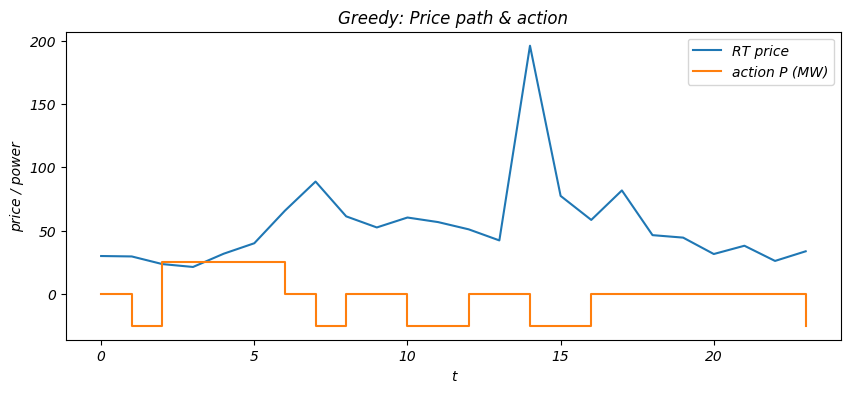

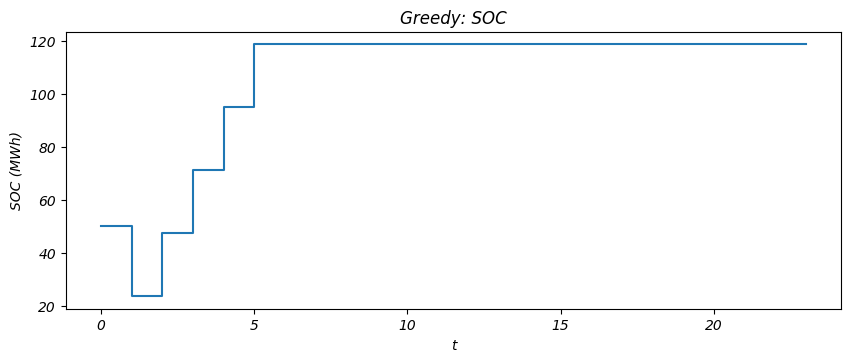

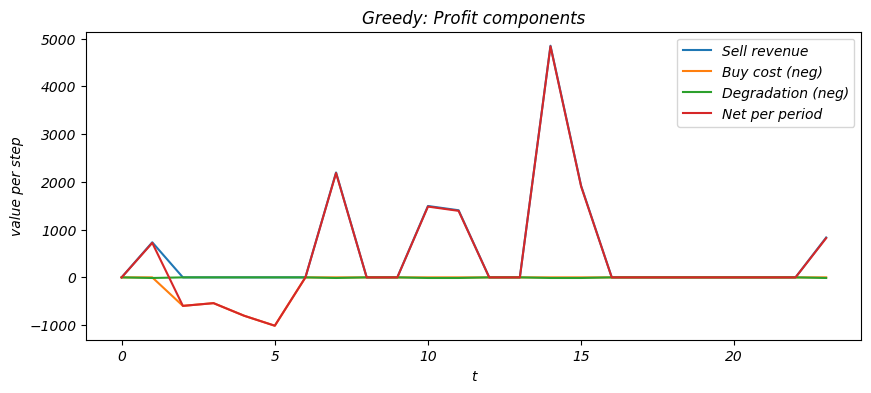

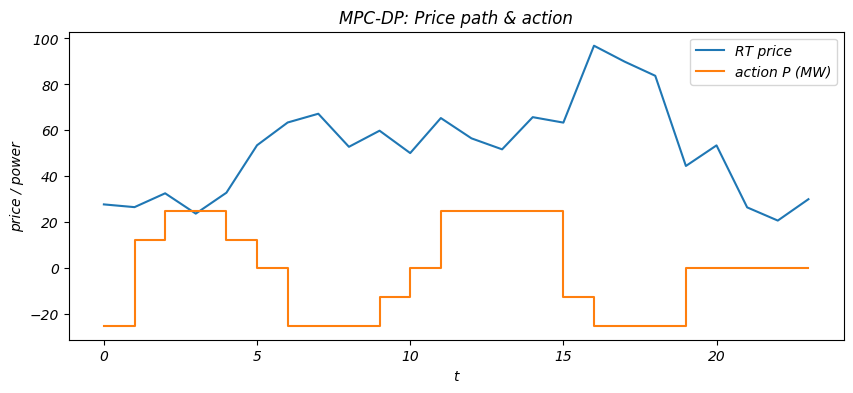

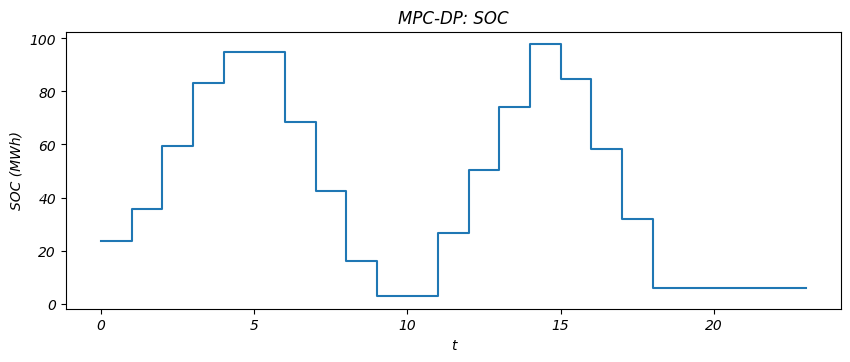

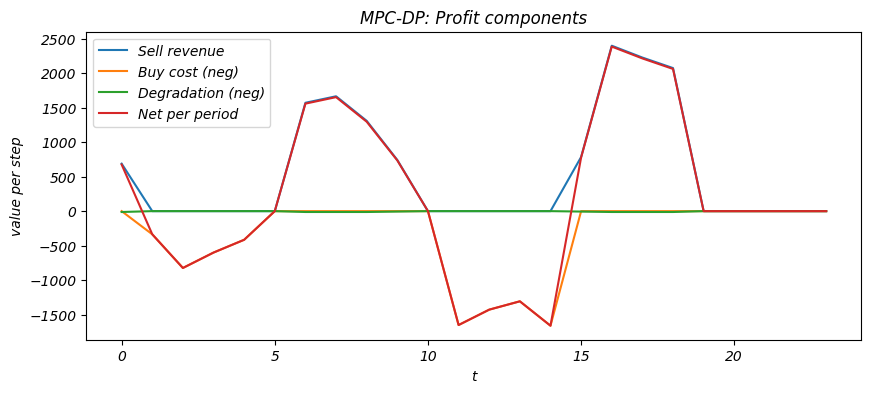

In [ ]:
base_da, rt_scen, batt, fric = generate_level1_instance(T=24, volatility=0.2, tail_risk_factor=0.05, seed=7)
T, N = rt_scen.shape
print(f"T={T}, N_scenarios={N}")
print("Battery:", batt)
print("Frictions:", fric)

rt_one = rt_scen[:, 0]

# NOTE TO DANIEL: this here should be probably given as a for loop, where rt gets updated at every iteration (to avoid lookahead)

# Greedy
gp = GreedyParams(buy_threshold=0.95, sell_threshold=1.05, soc_buffer_low=0.02, soc_buffer_high=0.02)
greedy_res = simulate_policy(rt_one, base_da, batt, fric, greedy_action, gp, delta_t=1.0)

# MPC-DP
mpc = MPCParams(horizon=6, soc_grid_size=51, action_levels=5, salvage_price=0.0, price_agg="mean")
mpc_res = simulate_mpc_dp(base_da, rt_scen, batt, fric, mpc, delta_t=1.0, seed=123)

print("Greedy: profit=", round(greedy_res["profit"], 2), "feasible:", greedy_res["feasible"])
print("MPC-DP: profit=", round(mpc_res["profit"], 2), "feasible:", mpc_res["feasible"])

plot_prices_with_action(rt_one, greedy_res["actions"], title="Greedy: Price path & action")
plot_soc(greedy_res["soc"], title="Greedy: SOC")
plot_profit_bars(greedy_res["charge_MW"], greedy_res["discharge_MW"], rt_one, fric, delta_t=1.0, title="Greedy: Profit components")

plot_prices_with_action(mpc_res["rt_realized"], mpc_res["actions"], title="MPC-DP: Price path & action")
plot_soc(mpc_res["soc"], title="MPC-DP: SOC")
plot_profit_bars(mpc_res["charge_MW"], mpc_res["discharge_MW"], mpc_res["rt_realized"], fric, delta_t=1.0, title="MPC-DP: Profit components")


## 8. Batch Evaluation (Proxy for Hidden Tests)


In [ ]:
def evaluate_many(base_da, rt_scen, batt, fric, E=256, seed=2025):
    rng = np.random.default_rng(seed)
    T, N = rt_scen.shape
    gp = GreedyParams()
    mpc = MPCParams(horizon=6, soc_grid_size=51, action_levels=5, salvage_price=0.0, price_agg="mean")

    greedy_profits, greedy_cycles, greedy_feas = [], [], 0
    mpc_profits, mpc_cycles, mpc_feas = [], [], 0

    for e in range(E):
        col = int(rng.integers(0, N))
        rt_realized = rt_scen[:, col]

        gres = simulate_policy(rt_realized, base_da, batt, fric, greedy_action, gp, delta_t=1.0)
        mres = simulate_mpc_dp(base_da, rt_scen, batt, fric, mpc, delta_t=1.0, seed=int(rng.integers(0, 10_000_000)))

        greedy_profits.append(gres["profit"]); mpc_profits.append(mres["profit"])
        greedy_feas += int(gres["feasible"]);  mpc_feas += int(mres["feasible"])
        greedy_cycles.append(cycles_from_trace(gres["discharge_MW"], 1.0, batt.capacity_mwh))
        mpc_cycles.append(cycles_from_trace(mres["discharge_MW"], 1.0, batt.capacity_mwh))

    def metrics(profits, cycles, feas):
        stats = eval_metrics(profits)
        stats["cycles"] = float(np.mean(cycles))
        stats["feasible_rate"] = feas / E
        return stats

    res = pd.DataFrame([
        {"policy": "Greedy",  **metrics(greedy_profits, greedy_cycles, greedy_feas)},
        {"policy": "MPC-DP",  **metrics(mpc_profits, mpc_cycles, mpc_feas)},
    ]).sort_values("expected_profit", ascending=False)
    return res

results = evaluate_many(base_da, rt_scen, batt, fric, E=256, seed=2025)
results

,policy,expected_profit,cvar_5,std,cycles,feasible_rate
1,MPC-DP,5946.066977,3.122884e+03,1334.901725,2.000000,1.00000
0,Greedy,-967894.940277,-1.001656e+06,175044.960492,1.433594,0.03125
